# < CycleGAN - Summer To Winter >

이 프로젝트는 CycleGAN을 통하여 여름 풍경 사진을 겨울 풍경 사진으로 변환하는 프로젝트입니다.

In [0]:
!pip install --upgrade tensorflow

In [0]:
!pip install h5py pyyaml

## (1) 데이터셋 다운로드

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from IPython.display import clear_output


from PIL import Image
import cv2


AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensorfow Dataset에서 summer2winter_yosemite 데이터 셋을 가져온 후, 분리한다.

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## (2) 데이터셋 학습 전 준비 과정

In [4]:
#이미지 주어진 크기에 따라 랜덤으로 분할,
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [5]:
# "-1 <= image <= 1" 로 변환
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [6]:
#이미지 변환 처리 중..
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [7]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [8]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [9]:
def preprocess_image_train_nl(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
class imagedata:
  def __init__(self, path,  w = 128, h = 192):
    self.outp = Image.open(path).convert("RGB")
    
    self.outp = self.outp.resize((w, h))
    area = (0, 0, int(w/4), int(h/4))
    self.inp = self.outp.crop(area)
    self.inp = self.inp.resize((w, h))
    self.oinp = self.inp
    self.ooutp = self.outp
    self.inp = np.array(self.oinp)
    self.outp = np.array(self.ooutp)
    self.inp = cv2.cvtColor(self.inp, cv2.COLOR_BGR2RGB)
    self.outp = cv2.cvtColor(self.outp, cv2.COLOR_BGR2RGB)
    self.inp = preprocess_image_train_nl(self.inp)
    self.outp = preprocess_image_train_nl(self.outp)

In [11]:
PATH_DIR='./Dataset/'
filelist = []

for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  try :
    filelist.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")

!$[VX-XP]- (1).png 파일 로드 완료
!$[VX-XP]- (14).png 파일 로드 완료
!$[VX-XP]- (17).png 파일 로드 완료
!$[VX-XP]- (18).png 파일 로드 완료
!$[VX-XP]- (23).png 파일 로드 완료
!$[VX-XP]- (3).png 파일 로드 완료
!$[VX-XP]- (31).png 파일 로드 완료
!$[VX-XP]- (33).png 파일 로드 완료
!$[VX-XP]- (34).png 파일 로드 완료
!$[VX-XP]- (35).png 파일 로드 완료
!$[VX-XP]- (36).png 파일 로드 완료
!$[VX-XP]- (39).png 파일 로드 완료
!$[VX-XP]- (4).png 파일 로드 완료
!$[VX-XP]- (42).png 파일 로드 완료
!$[VX-XP]- (44).png 파일 로드 완료
!$[VX-XP]- (45).png 파일 로드 완료
!$[VX-XP]- (5).png 파일 로드 완료
!$[VX-XP]- (50).png 파일 로드 완료
!$[VX-XP]- (51).png 파일 로드 완료
!$[VX-XP]- (52).png 파일 로드 완료
!$[VX-XP]- (53).png 파일 로드 완료
!$[VX-XP]- (54).png 파일 로드 완료
!$[VX-XP]- (55).png 파일 로드 완료
!$[VX-XP]- (56).png 파일 로드 완료
!$[VX-XP]- (57).png 파일 로드 완료


C:\Users\82105\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


!$[VX-XP]- (58).png 파일 로드 완료
!$[VX-XP]- (59).png 파일 로드 완료
!$[VX-XP]- (60).png 파일 로드 완료
!$[VX-XP]- (61).png 파일 로드 완료
!$[VX-XP]- (62).png 파일 로드 완료
!$[VX-XP]- (63).png 파일 로드 완료
!$[VX-XP]- (8).png 파일 로드 완료
!$[VX-XP]- (9).png 파일 로드 완료
$ 검붉은 갑옷의 백기사 여.png 파일 로드 완료
$ 악의 사자.png 파일 로드 완료
$01.png 파일 로드 완료
$010.png 파일 로드 완료
$011.png 파일 로드 완료
$012.png 파일 로드 완료
$02.png 파일 로드 완료
$03.png 파일 로드 완료
$04.png 파일 로드 완료
$05.png 파일 로드 완료
$06.png 파일 로드 완료
$07.png 파일 로드 완료
$08.png 파일 로드 완료
$09.png 파일 로드 완료
$1.png 파일 로드 완료
$10.png 파일 로드 완료
$11.png 파일 로드 완료
$12.png 파일 로드 완료
$13.png 파일 로드 완료
$14.png 파일 로드 완료
$15.png 파일 로드 완료
$16.png 파일 로드 완료
$16_yyy4195.png 파일 로드 완료
$17.png 파일 로드 완료
$18.png 파일 로드 완료
$19.png 파일 로드 완료
$2.png 파일 로드 완료
$20.png 파일 로드 완료
$21.png 파일 로드 완료
$22.png 파일 로드 완료
$23.png 파일 로드 완료
$24.png 파일 로드 완료
$25.png 파일 로드 완료
$26.png 파일 로드 완료
$27.png 파일 로드 완료
$28.png 파일 로드 완료
$29.png 파일 로드 완료
$3.png 파일 로드 완료
$30.png 파일 로드 완료
$31.png 파일 로드 완료
$32.png 파일 로드 완료
$33.png 파일 로드 완료
$34.png 파일 로드 완료
$35.png 파일 로드 완

## (3) 각 데이터셋의 첫 데이터를 띄운다.

## (4) CycleGAN 신경망 구성
> https://subinium.github.io/introduction-to-normalization/ : 정규화에 대한 글

In [12]:
#인스턴스 정규화 (IN) - 각 채널에서 정규화가 이루어짐
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [13]:
#다운샘플링 - UNET의 하강 부분에서 학습데이터를 압축하여 feature을 얻어내는 역할을 함.
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

#업샘플링 - UNET의 상승 부분에서 학습데이터를 압축 해제하여, 원래 학습 데이터와 해상도를 일치시키는 역할을 함.
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
#CycleGAN의 Generator 신경망을 U-NET으로 구성하는 역할을 함
def unet_generator(output_channels, norm_type='batchnorm'):
  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#CycleGAN의 Discriminato 신경망을 구성하는 역할을 함
def discriminator(norm_type='batchnorm', target=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

## (5) 신경망 준비
*Generator* 함수 **G**와 **F**는 ***역함수*** 관계</br>
*Discriminator* 함수 **X**와 **Y**는 ***역함수*** 관계

In [15]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [16]:
LAMBDA = 10

In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
#Discriminator 함수의 손실 구하기
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [19]:
#Generator 함수의 손실 구하기
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [20]:
#Generator을 통하여 변환된 이미지와 실제 이미지 사이의 손실 계산
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [21]:
#CycleGAN과 GAN의 차이인 "생성된 이미지 -> 원래 이미지"의 복원 가능성 손실 계산
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [22]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = random.permutation(a.shape[0])
    return a[p], b[p]

## (9) 학습 준비

In [23]:
#옵티마이저 설정
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
#만약 전에 학습시킨 모델이 있다면, 불러와서 이어서 학습 & 없다면 새로 학습
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [25]:
#학습 횟수
EPOCHS = 30000

In [26]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images(model, test_input):
  prediction = model(test_input[np.newaxis])
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  display_list = [test_input1, prediction1]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  plt.show()

In [27]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images_r(model, test_input, real_output):
  prediction = model(test_input[np.newaxis])
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  real_output1 = cv2.resize(real_output[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  display_list = [test_input1, prediction1, real_output1]
  title = ['Input Image', 'Predicted Image', 'Real Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  
  plt.show()

In [28]:
def sampling(train_x, train_y, batch_size) :
  train_xb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  train_yb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  listaa = np.arange(train_x.shape[0])
  listaa = np.random.choice(listaa, batch_size, replace=False)
  for i in listaa:
    train_xb = np.append(train_xb, train_x[i][np.newaxis], axis=0)
    train_yb = np.append(train_yb, train_y[i][np.newaxis], axis=0)
  return train_xb, train_yb

## (10) 학습 함수 구성

In [29]:
#학습 함수
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G 는 X -> Y 로 변환
    # Generator F 는 Y -> X 로 변환


    fake_y = generator_g(real_x, training=True)

    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)

    cycled_y = generator_g(fake_x, training=True)

    # same_x & same_y 는 "생성된 이미지 -> 원래 이미지"의 복원 가능성 손실 계산에 이용됨.
    same_x = generator_f(real_x, training=True)

    same_y = generator_g(real_y, training=True)


    
    disc_real_x = discriminator_x(real_x, training=True)

    disc_real_y = discriminator_y(real_y, training=True)


    disc_fake_x = discriminator_x(fake_x, training=True)

    disc_fake_y = discriminator_y(fake_y, training=True)


    # 해당 손실 연산
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # 총합 손실 연산 (Generator_g의 역함수 Generator_f에 대한 손실 계산 삭제)
    total_gen_g_loss = gen_g_loss + total_cycle_loss# + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss# + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # 가중치 연산

  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)

  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)

  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # 가중치 갱신

  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
  return total_gen_g_loss


In [30]:
def cal_g_loss(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G 는 X -> Y 로 변환
    # Generator F 는 Y -> X 로 변환


    fake_y = generator_g(real_x, training=True)

    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)

    cycled_y = generator_g(fake_x, training=True)

    # same_x & same_y 는 "생성된 이미지 -> 원래 이미지"의 복원 가능성 손실 계산에 이용됨.
    same_x = generator_f(real_x, training=True)

    same_y = generator_g(real_y, training=True)


    
    disc_real_x = discriminator_x(real_x, training=True)

    disc_real_y = discriminator_y(real_y, training=True)


    disc_fake_x = discriminator_x(fake_x, training=True)

    disc_fake_y = discriminator_y(fake_y, training=True)


    # 해당 손실 연산
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # 총합 손실 연산 (Generator_g의 역함수 Generator_f에 대한 손실 계산 삭제)
    total_gen_g_loss = gen_g_loss + total_cycle_loss# + identity_loss(real_y, same_y)
  return total_gen_g_loss

In [31]:
train_x = []
train_y = []

for i in filelist:
  print("인풋 배열 크기 : " + str(i.inp.shape))
  print("아웃풋 배열 크기" + str(i.outp.shape))
  train_x.append(i.inp)
  train_y.append(i.outp)

인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 256, 3)
인풋 배열 크기 : (256, 256, 3)
아웃풋 배열 크기(256, 

In [32]:
from random import sample
import random
def sampling_list(a, b, batch):
  batches = [random.randint(0,len(a)-1) for r in range(0, batch)]
  c = []
  d = []
  for j in batches:
    c.append(a[j])
    d.append(b[j])
  g = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  h = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  for i in range(0, batch):
    g = np.append(g, c[i][np.newaxis], axis=0)
    h = np.append(h, d[i][np.newaxis], axis=0)
  return g, h

In [33]:
'''train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
train_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')

numi = 1
for i in filelist:
  #print("인풋 배열 크기 : " + str(i.inp.shape))
  #print("아웃풋 배열 크기" + str(i.outp.shape))
  #train_x.append(i.inp)
  print(str(numi) + "번째 이미지 로드 중..")
  
  train_x = np.append(train_x, i.inp[np.newaxis], axis=0)
  train_y = np.append(train_y, i.outp[np.newaxis], axis=0)
  
  if train_x.shape[0] % 500 == 0 and train_y.shape[0] % 500 == 0:
    print("================================================================================================================")
    np.save("saved_array/train_x", train_x)
    np.save("saved_array/train_y", train_y)
    f = open("saved_array/textnum.txt", 'w')
    f.write(str(numi))
    f.close()
    
    print("= "+str(numi)+"번쨰 배열 파일 세이브 완료")
    print("================================================================================================================")
  numi = numi + 1
  #train_y.append(i.outp)
    '''

'train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype=\'float32\')\ntrain_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype=\'float32\')\n\nnumi = 1\nfor i in filelist:\n  #print("인풋 배열 크기 : " + str(i.inp.shape))\n  #print("아웃풋 배열 크기" + str(i.outp.shape))\n  #train_x.append(i.inp)\n  print(str(numi) + "번째 이미지 로드 중..")\n  \n  train_x = np.append(train_x, i.inp[np.newaxis], axis=0)\n  train_y = np.append(train_y, i.outp[np.newaxis], axis=0)\n  \n  if train_x.shape[0] % 500 == 0 and train_y.shape[0] % 500 == 0:\n    print("================================================================================================================")\n    np.save("saved_array/train_x", train_x)\n    np.save("saved_array/train_y", train_y)\n    f = open("saved_array/textnum.txt", \'w\')\n    f.write(str(numi))\n    f.close()\n    \n    print("= "+str(numi)+"번쨰 배열 파일 세이브 완료")\n    print("========================================================================================================

In [34]:
def readago():
    f = open("saved_loss/textnum.txt", "r")
    lines = f.read()
    f.close()
    losstrainlist = []
    losstestlist = []
    for i in lines.split("\n"):
        if i == "[losslog]" :
            continue
        losstrainlist.append(float(i.split(":")[1]))
        losstestlist.append(float(i.split(":")[2]))
        
    return losstrainlist, losstestlist

In [35]:
def drawlossg(ll1, ll2):
    y1 = ll1
    x1 = range(1, len(ll1)+1)
    y2 = ll2
    x2 = range(1, len(ll2)+1)
    
    plt.plot(x1, y1, x2, y2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Loss Graph")
    plt.legend(['Train', 'Test'], loc=0)
    plt.show()

In [36]:
def saveloss(epoch, loss1, loss2):
    f = open("saved_loss/textnum.txt", "a")
    f.write("\n{0}:{1}:{2}".format(str(epoch), str(loss1.numpy()), str(loss2.numpy())))
    f.close()
    return loss1.numpy(), loss2.numpy()

In [37]:
PATH_DIR='./testinput/'
testlist = []

for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge") or file.endswith(".bmp")]:
  try :
    testlist.append(imagedata(PATH_DIR + str(i)))
  except :
    print(str(i)+" 파일 로드 실패")
    continue
  print(str(i)+" 파일 로드 완료")

test_x = []
test_y = []
for i in testlist:
  test_x.append(i.inp)
  test_y.append(i.outp)

Render4009.png 파일 로드 완료
Render4019.png 파일 로드 완료
Render4028.png 파일 로드 완료
Render4048.png 파일 로드 완료
Render4081.png 파일 로드 완료
Render4085.png 파일 로드 완료
Render4089.png 파일 로드 완료
Render4098.png 파일 로드 완료
Render4103.png 파일 로드 완료
Render4107.png 파일 로드 완료
Render4228.png 파일 로드 완료
Render4235.png 파일 로드 완료
Render4256.png 파일 로드 완료
Render4306.png 파일 로드 완료
Render4308.png 파일 로드 완료


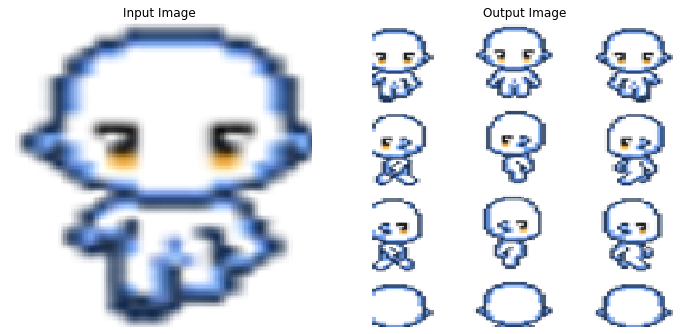

In [38]:
plt.figure(figsize=(12, 12))
display_list = [train_x[0], train_y[0]]
title = ['Input Image', 'Output Image']
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5)
  plt.axis('off')

plt.show()

## (11) 학습 시작

==================================테스트 이미지 비교================================


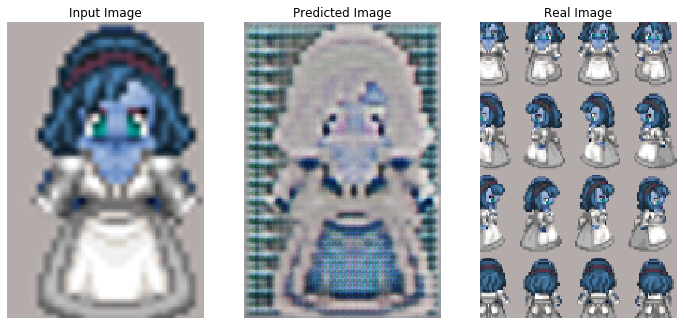

==================================손실 그래프================================


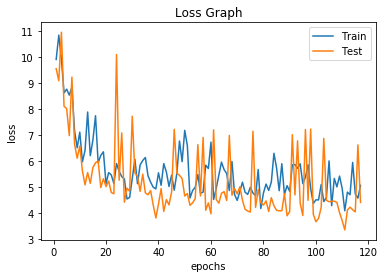

118번째 학습 시작


In [ ]:
losstrainlist, losstestlist = readago()
cepoch=len(losstrainlist)

print()
for epoch in range(EPOCHS):


  a, b = sampling_list(train_x, train_y, 15)
  c, d = sampling_list(test_x, test_y, 3)
  print("{0}번째 학습 시작".format(epoch+cepoch+1))
  losstrain = train_step(a, b)
  losstest = cal_g_loss(c, d, generator_g, generator_f, discriminator_x, discriminator_y)
  print("{0}번째 학습 완료".format(epoch+cepoch+1))
  loss1, loss2 = saveloss(epoch+cepoch+1, losstrain, losstest)
  losstrainlist.append(loss1)
  losstestlist.append(loss2)
  print("{0}번째 학습 로그 작성 완료".format(epoch+cepoch+1))
  '''
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_x, train_y)):
    print("for문 진입")
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1'''

  
  
  

  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  #print("==================================학습 이미지 비교================================")
  #generate_images_r(generator_g, a[0], b[0])
  print("==================================테스트 이미지 비교================================")
  generate_images_r(generator_g, c[0], d[0])
  if epoch+cepoch+1 >= 3 :
    print("==================================손실 그래프================================")
    drawlossg(losstrainlist, losstestlist)

  if (epoch + 1) % 5 == 0:
    try :
      ckpt_save_path = ckpt_manager.save()
    except :
      pass
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+cepoch+1,
                                                         ckpt_save_path))

## (12) 테스트 데이터에서 몇개를 추출하여 변환 테스트

In [ ]:
generate_images_r(generator_g, train_x[0], train_y[0])

In [41]:
generator_g.save('saved_model/generator_g', save_format='tf')
print("generator_g 저장 완료")
generator_f.save('saved_model/generator_f', save_format='tf')
print("generator_f 저장 완료")
discriminator_x.save('saved_model/discriminator_x', save_format='tf')
print("discriminator_x 저장 완료")
discriminator_y.save('saved_model/discriminator_y', save_format='tf')
print("discriminator_y 저장 완료")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/generator_g\assets


INFO:tensorflow:Assets written to: saved_model/generator_g\assets


generator_g 저장 완료
INFO:tensorflow:Assets written to: saved_model/generator_f\assets


INFO:tensorflow:Assets written to: saved_model/generator_f\assets


generator_f 저장 완료
INFO:tensorflow:Assets written to: saved_model/discriminator_x\assets


INFO:tensorflow:Assets written to: saved_model/discriminator_x\assets


discriminator_x 저장 완료
INFO:tensorflow:Assets written to: saved_model/discriminator_y\assets


INFO:tensorflow:Assets written to: saved_model/discriminator_y\assets


discriminator_y 저장 완료


In [ ]:
def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [ ]:
modelaa = tf.keras.models.Sequential()
modelaa = tf.keras.models.load_model('./saved_model/generator_g.h5')
generate_images_r(modelaa, train_x[0], train_y[0])

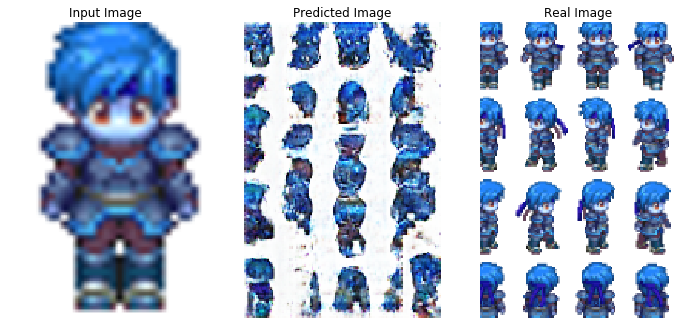

In [43]:
model = tf.keras.models.load_model('saved_model/generator_g')
generate_images_r(model, train_x[0], train_y[0])